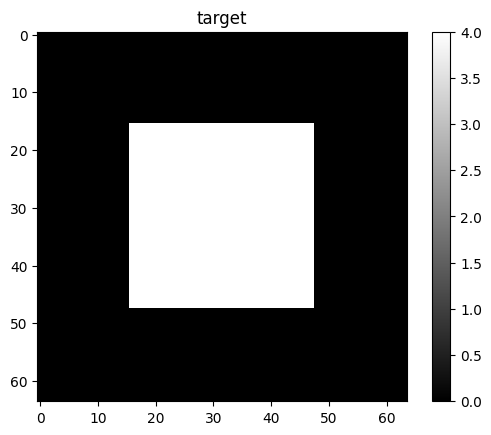

[[ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]
 ...
 [ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]]


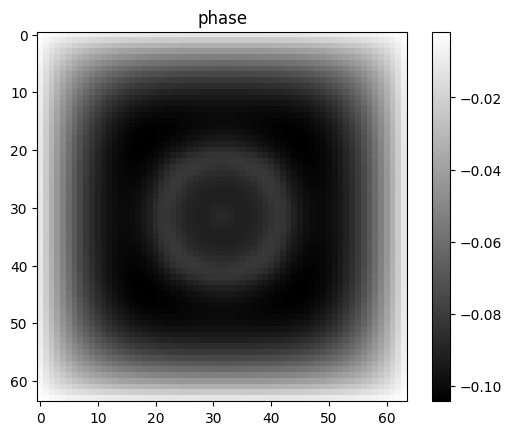

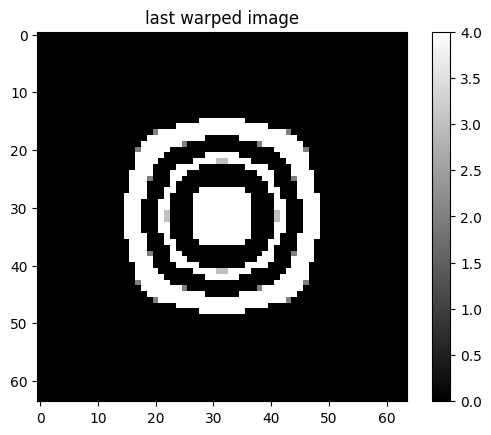

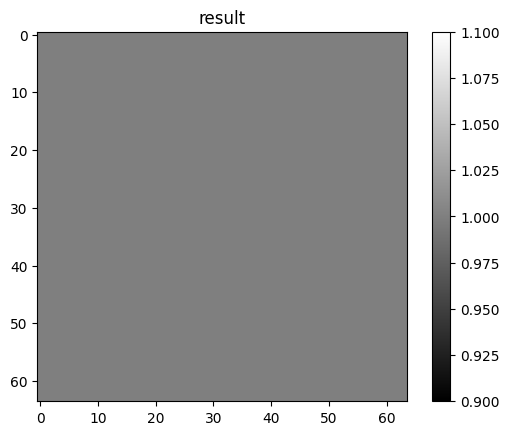

In [ ]:
#the third optimal method
import cv2 as op    #图像处理
import numpy as np #数组矩阵处理
from scipy import ndimage #求各方向梯度
from scipy.sparse.linalg import bicgstab    #共轭梯度法
import matplotlib.pyplot as plt #灰度图显示
import math

#预先准备函数部分
#线性插值
def single_biline(x,x0,x1,in1,in2):
    alpha=abs(x-x0)
    y=alpha*in1+(1-alpha)*in2
    return y

#二维laplacian算子
def discrete_laplacian_2d_matrix(m, n):
    """
    生成一个m x n的二维离散拉普拉斯算子的系统矩阵。
    参数:
    m, n -- 矩阵的行和列的大小
    返回:
    L -- 二维离散拉普拉斯算子的系统矩阵
    """
    # 初始化矩阵
    L = np.zeros((m * n, m * n))
    
    # 遍历每个像素点
    for i in range(m):
        for j in range(n):
            idx = i * n + j  # 当前像素的索引
            # 计算拉普拉斯算子
            if i > 0:  # 上
                L[idx, idx - n] = 1
            if i < m - 1:  # 下
                L[idx, idx + n] = 1
            if j > 0:  # 左
                L[idx, idx - 1] = 1
            if j < n - 1:  # 右
                L[idx, idx + 1] = 1
            # 主对角线元素
            L[idx, idx] = -4
    
    return L

#定义目标图像和入射光束平面光强,每个单元格边长为160um,比例为6250:1,焦距应为20cm，同时按照比例来定义程序下焦距
row=64  #行
col=64  #列
target=np.zeros((row,col))
target[16:48,16:48]=4#目标光强
im_map=target.copy()#扭曲的图像结果
f=1250#按照比例折算而来，为离散化坐标系下定义焦距
incident=np.ones((row,col))#入射平面光束照度分布

#incident[1:30,1:30]=-3 验证负数是否可以用plt表示出来

#画图核实入射光束以及目标光强
plt.imshow(target, cmap='gray')
plt.colorbar()
plt.title('target')
plt.show()

#光源平面索引下标
I=np.tile(np.arange(row).reshape(row,1),(1,col))
J=np.tile(np.arange(col),(row,1))
I_J=[I,J]
print(J)
#光源平面实际物理坐标(1:160um)
X=I*0.00016
Y=J*0.00016

#laplacian矩阵
L_2D=discrete_laplacian_2d_matrix(row,col)

#迭代进行优化
for count in range(1,5):
    target_delete=-im_map+np.ones((row,col))
    #把原来图像化成列向量
    target_col=target_delete.reshape(-1,1)
    
    #使用双共轭梯度稳定迭代法求解 Ax = b
    p,exitcode=bicgstab(L_2D,target_col,atol=1)
    
    #求出p(x)，需要除去焦距,并且由列向量转为矩阵
    p=p/f
    p=p.reshape(row,col)
    
    # 计算矩阵 p 的 Sobel 梯度，并乘以实际的焦距长度（0.2m）
    dp_dx = f*ndimage.sobel(p, axis=0)  # x 方向上的梯度
    dp_dy = f*ndimage.sobel(p, axis=1)  # y 方向上的梯度
    
     # 映射后的目标平面实际物理坐标
    X_T = (I + dp_dx).astype(np.float32)
    Y_T = (J + dp_dy).astype(np.float32)

    #转为目标平面索引坐标
    I_T=X_T
    J_T=Y_T
    
    # 双线性插值,扭曲原来的图像
    for ci in range(0,row):
        for cj in range(0,col):
          #边界溢出处理
          if I_T[ci,cj]<0:
                I_T[ci,cj]=0
          if I_T[ci,cj]>row-1:
                I_T[ci,cj]=row-1
          if J_T[ci,cj]<0:
                J_T[ci,cj]=0
          if J_T[ci,cj]>col-1:
                J_T[ci,cj]=col-1
                
          #边界处理完毕后开始正式处理
          x0=int(math.floor(I_T[ci,cj]))
          x1=int(math.ceil(I_T[ci,cj]))
          y0=int(math.floor(J_T[ci,cj]))
          y1=int(math.ceil(J_T[ci,cj]))
          
          #将坐标对应到image_target上的强度
          in_1=target[x0,y0]
          in_2=target[x1,y0]
          in_3=target[x0,y1]
          in_4=target[x1,y1]
          
          p1=single_biline(I_T[ci,cj],x0,x1,in_1,in_2)
          p2=single_biline(I_T[ci,cj],x0,x1,in_3,in_4)
          p3=single_biline(J_T[ci,cj],y0,y1,p1,p2)
          im_map[ci,cj]=np.array(p3,dtype=np.uint8)
          
    #图像扭曲完毕后，重新进行迭代
          
 

#检验结果前预先得到f*laplacian*p(x)
p_temp=p.reshape(-1,1)#转为列向量
indensity=f*L_2D*p_temp
indensity=np.ones(row,col)-indensity.reshape(row,col)#转回矩阵


#检验结果
result=np.zeros((row,col))
for ci in range(0,row):
    for cj in range(0,col):
        #边界溢出处理
        if I_T[ci,cj]<0:
             I_T[ci,cj]=0
        if I_T[ci,cj]>row-1:
             I_T[ci,cj]=row-1
        if J_T[ci,cj]<0:
             J_T[ci,cj]=0
        if J_T[ci,cj]>col-1:
            J_T[ci,cj]=col-1
                
        #边界处理完毕后开始正式处理
        x0=int(math.floor(I_T[ci,cj]))
        x1=int(math.ceil(I_T[ci,cj]))
        y0=int(math.floor(J_T[ci,cj]))
        y1=int(math.ceil(J_T[ci,cj]))
          
        #将坐标对应到incident上的强度
        in_1=incident[x0,y0]
        in_2=incident[x1,y0]
        in_3=incident[x0,y1]
        in_4=incident[x1,y1]
          
        p1=single_biline(I_T[ci,cj],x0,x1,in_1,in_2)
        p2=single_biline(I_T[ci,cj],x0,x1,in_3,in_4)
        p3=single_biline(J_T[ci,cj],y0,y1,p1,p2)
        result[ci,cj]=np.array(p3,dtype=np.uint8) 
 
 
 
          
#最后一次图像扭曲的结果
plt.imshow(p, cmap='gray')
plt.colorbar()
plt.title('phase')
plt.show()
#映射结果
plt.imshow(im_map, cmap='gray')
plt.colorbar()
plt.title('last warped image')
plt.show()
#最终结果
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title('result')
plt.show()


In [7]:
import cv2 as op    #图像处理
import numpy as np #数组矩阵处理
import math

row=5
col=5
I=np.tile(np.arange(row).reshape(row,1),(1,col))
J=np.tile(np.arange(col),(row,1))
I_J=[I,J]

print(I_J)


[array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]]), array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])]
